# Data Collection

In [ ]:
!wget http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/underhang.zip

--2022-02-05 20:48:21--  http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/underhang.zip
Resolving www02.smt.ufrj.br (www02.smt.ufrj.br)... 146.164.99.22
Connecting to www02.smt.ufrj.br (www02.smt.ufrj.br)|146.164.99.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3679617780 (3.4G) [application/zip]
Saving to: ‘underhang.zip’

underhang.zip       100%[===================>]   3.43G  11.1MB/s    in 5m 20s  

2022-02-05 20:53:41 (11.0 MB/s) - ‘underhang.zip’ saved [3679617780/3679617780]



In [ ]:
!mv /content/underhang.zip /content/drive/MyDrive/FYP_FINAL/UHBF

In [ ]:
!unzip /content/drive/MyDrive/FYP_FINAL/normal.zip
!unzip /content/drive/MyDrive/FYP_FINAL/UHBF/underhang.zip

# Imports & Functions

In [ ]:
# Installing libraries required
!pip install mat73
!pip install ewtpy
!pip install scaleogram

In [ ]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.io import loadmat
from scipy import signal
import mat73

import random
import pywt
import gc
import scaleogram as scg 

from skimage.transform import resize
from skimage import data, color
import ewtpy

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split


import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import itertools

from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.recurrent import LSTM
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Concatenate,Average



In [ ]:
def make_confusion_matrix(y_true,y_pred,classes=None, figsize=(10,10),text_size=15):
        """
        # Note: The following confusion matrix code is a remix of Scikit-Learn's 
        # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
        # and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
        """
    
        cm = confusion_matrix(y_true, tf.round(y_pred))
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0]

        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
        fig.colorbar(cax)

        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])


        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes),
                yticks=np.arange(n_classes),
                xticklabels=labels,
                yticklabels=labels)

    
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

    
        threshold = (cm.max() + cm.min()) / 2.


        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

In [ ]:
cur_path = "/content/"
normal_path = glob.glob(cur_path+'/normal/*.csv',recursive=True)
UHBF_0_g_path = glob.glob(cur_path+'/underhang/ball_fault/0g/*.csv',recursive=True)
UHBF_6_g_path = glob.glob(cur_path+'/underhang/ball_fault/6g/*.csv',recursive=True)
UHBF_20_g_path = glob.glob(cur_path+'/underhang/ball_fault/20g/*.csv',recursive=True)
UHBF_35_g_path = glob.glob(cur_path+'/underhang/ball_fault/35g/*.csv',recursive=True)
UHCF_0_g_path = glob.glob(cur_path+'/underhang/cage_fault/0g/*.csv',recursive=True)
UHCF_6_g_path = glob.glob(cur_path+'/underhang/cage_fault/6g/*.csv',recursive=True)
UHCF_20_g_path = glob.glob(cur_path+'/underhang/cage_fault/20g/*.csv',recursive=True)
UHCF_35_g_path = glob.glob(cur_path+'/underhang/cage_fault/35g/*.csv',recursive=True)
UHOR_0_g_path = glob.glob(cur_path+'/underhang/outer_race/0g/*.csv',recursive=True)
UHOR_6_g_path = glob.glob(cur_path+'/underhang/outer_race/6g/*.csv',recursive=True)
UHOR_20_g_path = glob.glob(cur_path+'/underhang/outer_race/20g/*.csv',recursive=True)
UHOR_35_g_path = glob.glob(cur_path+'/underhang/outer_race/35g/*.csv',recursive=True)


In [ ]:
columns=["Tachometer signal","ax_UBA","r_UBA","tan_UBA","ax_OBA","r_OBA","tan_OBA","mic"]

## Visualisation and Downsampling

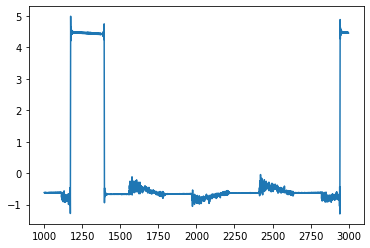

In [ ]:
pd.read_csv(normal_path[0],header=None)[1000:3000].iloc[:,0].plot()

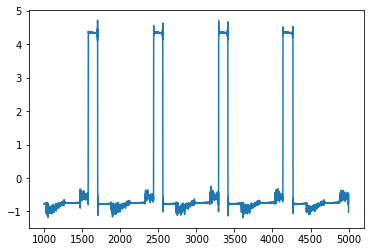

In [ ]:
pd.read_csv(UHBF_0_g_path[0],header=None)[1000:5000].iloc[:,0].plot()

In [ ]:
num_samples=5000
def resampler(path):
    data_n = pd.DataFrame()
    for i in path:
        _data = pd.read_csv(i,header=None).to_numpy()
        resampled_df=pd.DataFrame()
        for j in range(8):
          resample=pd.DataFrame(signal.resample(_data[:,j],num_samples))
          resampled_df=pd.concat([resampled_df,resample],axis=1,ignore_index=True)

        data_n = pd.concat([data_n,resampled_df],ignore_index=True)
    return data_n

In [ ]:
data_n = resampler(normal_path)
data_uhbf_0g = resampler(UHBF_0_g_path)
data_uhbf_6g = resampler(UHBF_6_g_path)
data_uhbf_20g = resampler(UHBF_20_g_path)
data_uhbf_35g = resampler(UHBF_35_g_path)
data_uhcf_0g = resampler(UHCF_0_g_path)
data_uhcf_6g = resampler(UHCF_6_g_path)
data_uhcf_20g = resampler(UHCF_20_g_path)
data_uhcf_35g = resampler(UHCF_35_g_path)
data_uhor_0g = resampler(UHOR_0_g_path)
data_uhor_6g = resampler(UHOR_6_g_path)
data_uhor_20g = resampler(UHOR_20_g_path)
data_uhor_35g = resampler(UHOR_35_g_path)

In [ ]:
data_n.shape,data_uhbf_0g.shape 

((245000, 8), (250000, 8))

In [ ]:
data_n.columns=columns
data_uhbf_0g.columns=columns
data_uhbf_6g.columns=columns
data_uhbf_20g.columns=columns
data_uhbf_35g.columns=columns
data_uhcf_0g.columns=columns
data_uhcf_6g.columns=columns
data_uhcf_20g.columns=columns
data_uhcf_35g.columns=columns
data_uhor_0g.columns=columns
data_uhor_6g.columns=columns
data_uhor_20g.columns=columns
data_uhor_35g.columns=columns

In [ ]:
data_n

,Tachometer signal,ax_UBA,r_UBA,tan_UBA,ax_OBA,r_OBA,tan_OBA,mic
0,-0.566699,0.023993,-0.138019,-0.033846,-0.114549,-0.030432,0.234611,0.008049
1,-0.618317,-0.858789,-0.364228,-0.100950,1.007410,-0.006428,0.643547,0.107461
2,-0.714102,-0.703387,-0.249679,0.014161,0.671108,-0.005139,0.458381,0.067097
3,-0.611934,-0.645705,-0.386828,-0.069429,0.517288,-0.021504,0.537464,0.086510
4,-0.703227,-0.648516,0.307910,-0.083815,0.705244,0.007486,0.459270,0.047342
...,...,...,...,...,...,...,...,...
244995,-0.463714,-0.080637,-0.398921,0.010602,-0.104984,0.038468,-0.402640,0.021514
244996,-0.927827,0.445052,0.109670,-0.064875,0.283170,-0.027890,-0.486455,-0.024483
244997,-0.533009,-0.637016,0.056928,0.030377,1.057244,-0.019036,-0.621422,0.058483
244998,-0.870199,-0.739922,-0.410291,-0.017780,0.948341,-0.032512,-0.431243,0.040577


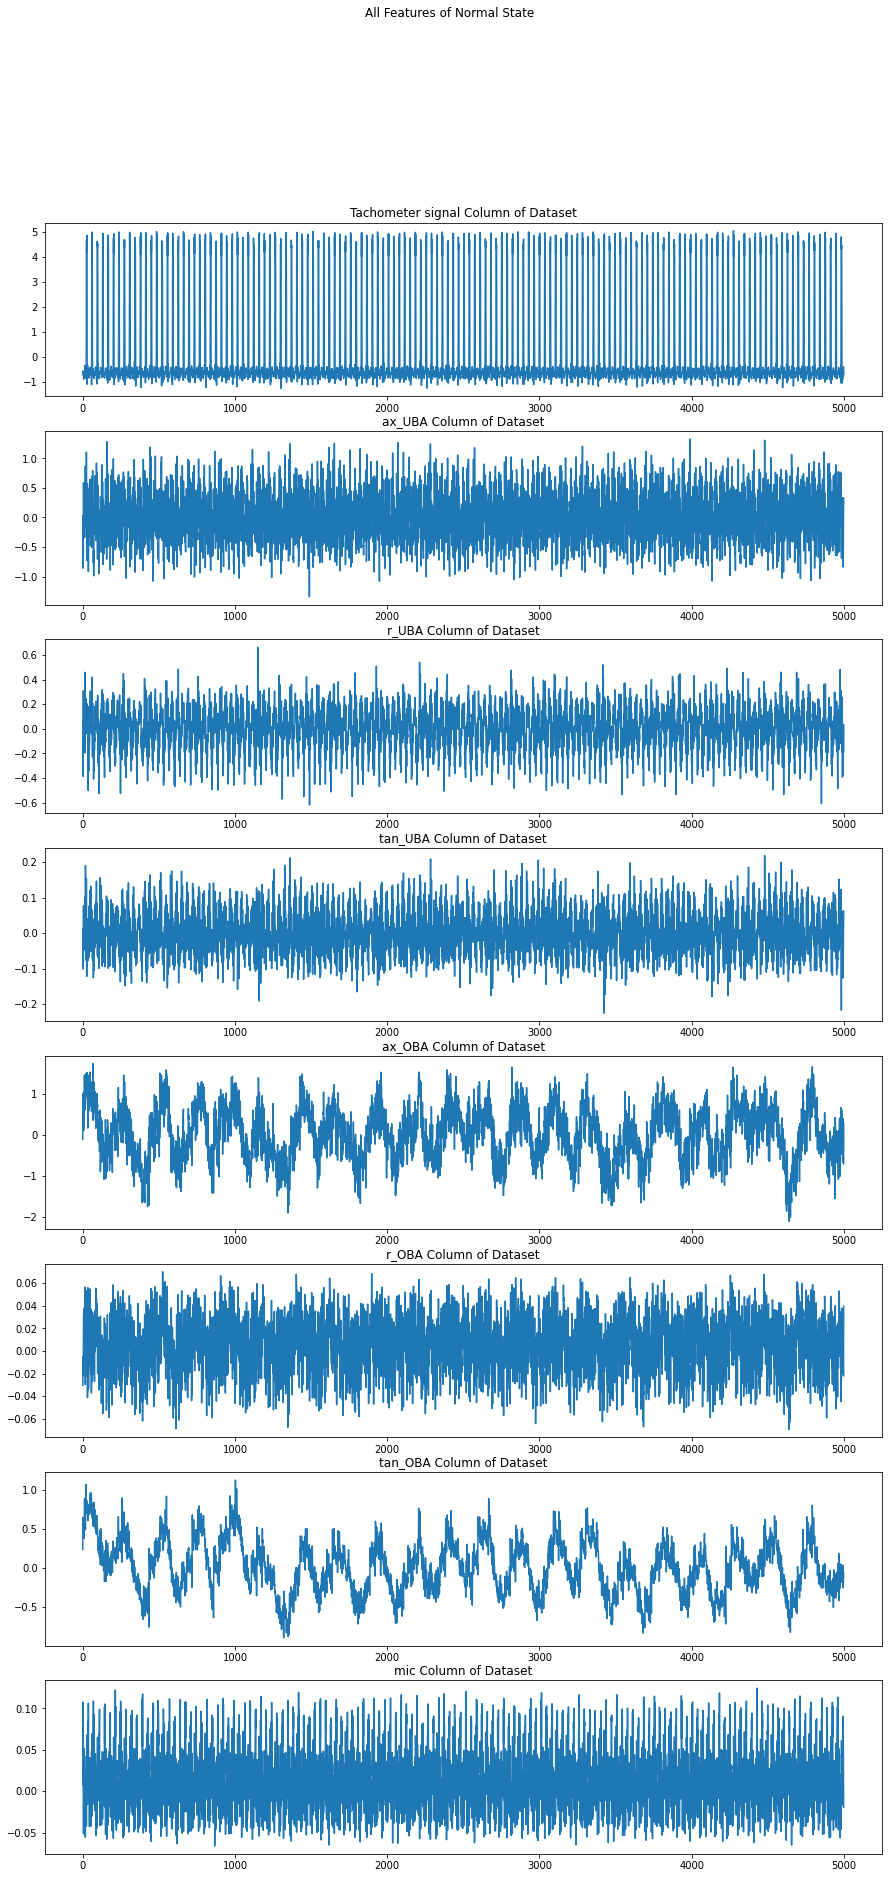

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Normal State')
for i in range(len(data_n.columns)):
    axs[i].plot(data_n[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

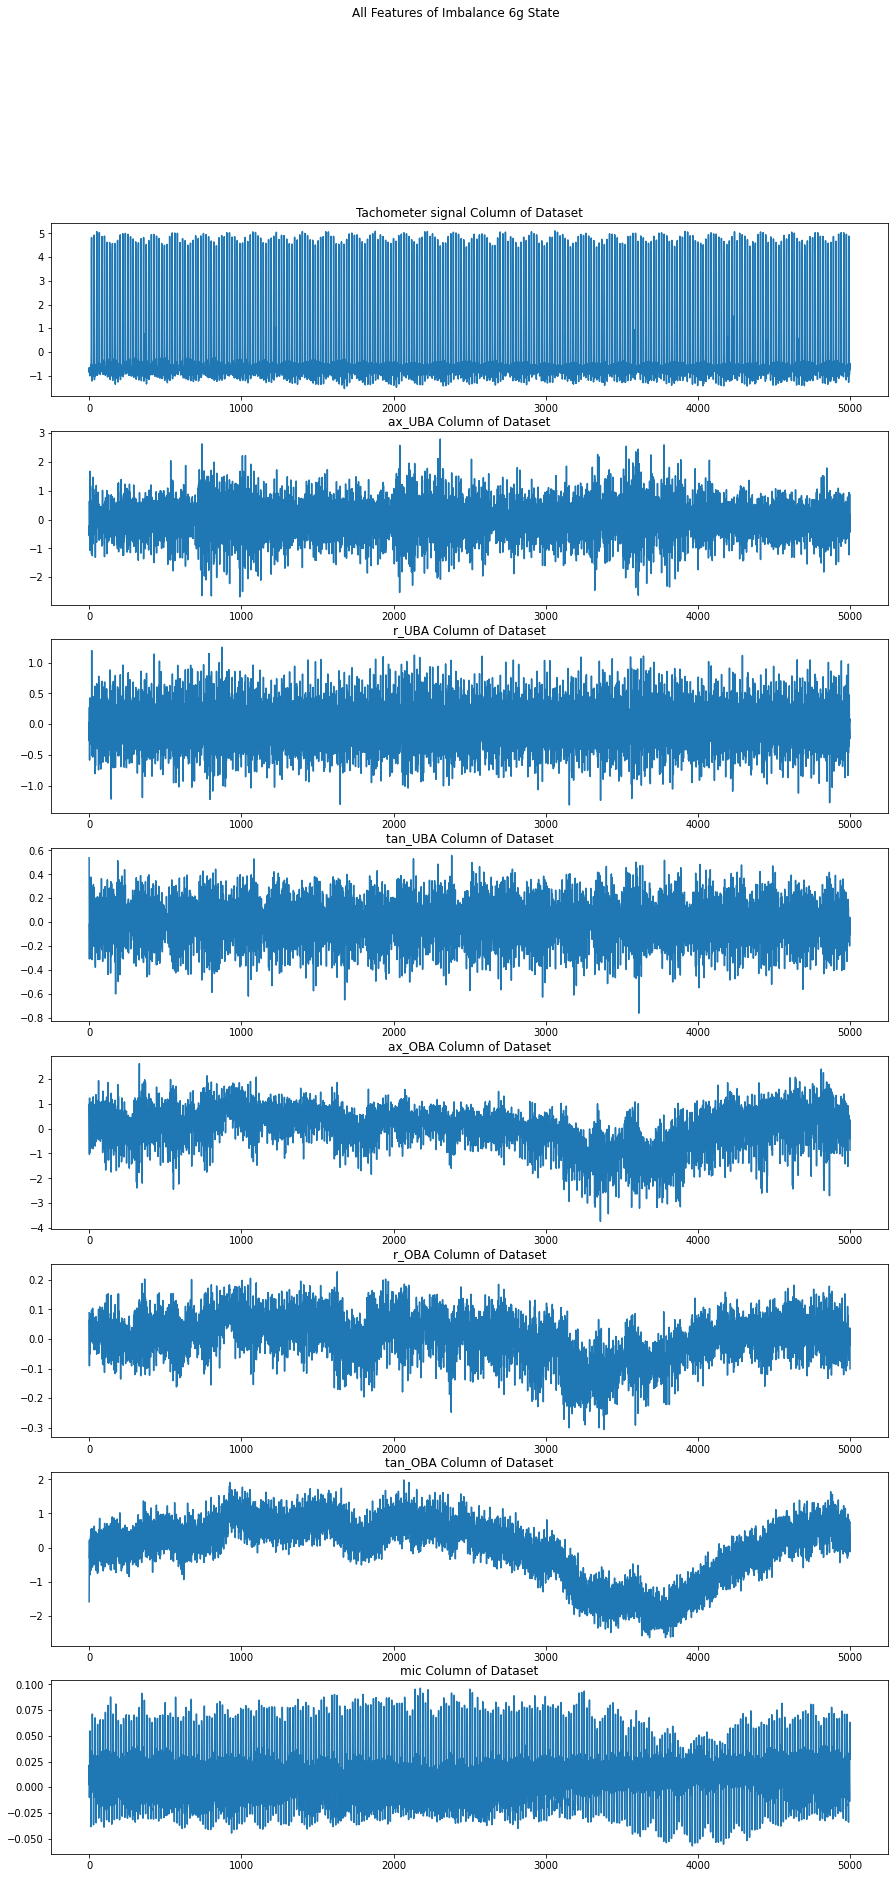

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Imbalance 6g State')
for i in range(len(data_uhbf_0g.columns)):
    axs[i].plot(data_uhbf_0g[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

# Data Preprocessing

In [ ]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245000 entries, 0 to 244999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Tachometer signal  245000 non-null  float64
 1   ax_UBA             245000 non-null  float64
 2   r_UBA              245000 non-null  float64
 3   tan_UBA            245000 non-null  float64
 4   ax_OBA             245000 non-null  float64
 5   r_OBA              245000 non-null  float64
 6   tan_OBA            245000 non-null  float64
 7   mic                245000 non-null  float64
dtypes: float64(8)
memory usage: 15.0 MB


Underhang


Weight (g)	Measurements
0	49
6	48
20	49
35	42
Total	188

Weight (g)	Measurements
0	49
6	49
20	49
35	37
Total	184


Weight (g)	Measurements
0	50
6	49
20	49
35	38
Total	186

 Normal	49

In [ ]:
x_0=data_n.to_numpy().reshape(-1,num_samples,8)
x_1=data_uhbf_0g.to_numpy().reshape(-1,num_samples,8)
x_2=data_uhbf_6g.to_numpy().reshape(-1,num_samples,8)
x_3=data_uhbf_20g.to_numpy().reshape(-1,num_samples,8)
x_4=data_uhbf_35g.to_numpy().reshape(-1,num_samples,8)
x_5=data_uhcf_0g.to_numpy().reshape(-1,num_samples,8)
x_6=data_uhcf_6g.to_numpy().reshape(-1,num_samples,8)
x_7=data_uhcf_20g.to_numpy().reshape(-1,num_samples,8)
x_8=data_uhcf_35g.to_numpy().reshape(-1,num_samples,8)
x_9=data_uhor_0g.to_numpy().reshape(-1,num_samples,8)
x_10=data_uhor_6g.to_numpy().reshape(-1,num_samples,8)
x_11=data_uhor_20g.to_numpy().reshape(-1,num_samples,8)
x_12=data_uhor_35g.to_numpy().reshape(-1,num_samples,8)

In [ ]:
X_data=np.vstack((x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12))
X_data.shape

(607, 5000, 8)

In [ ]:
y_0 = pd.DataFrame(np.zeros(int(len(x_0)),dtype=int))
y_1 = pd.DataFrame(np.ones(int(len(x_1)),dtype=int))
y_2 = pd.DataFrame(np.full((int(len(x_2)),1),2))
y_3 = pd.DataFrame(np.full((int(len(x_3)),1),3))
y_4 = pd.DataFrame(np.full((int(len(x_4)),1),4))
y_5 = pd.DataFrame(np.full((int(len(x_5)),1),5))
y_6 = pd.DataFrame(np.full((int(len(x_6)),1),6))
y_7 = pd.DataFrame(np.full((int(len(x_7)),1),7))
y_8 = pd.DataFrame(np.full((int(len(x_8)),1),8))
y_9 = pd.DataFrame(np.full((int(len(x_9)),1),9))
y_10 = pd.DataFrame(np.full((int(len(x_10)),1),10))
y_11 = pd.DataFrame(np.full((int(len(x_11)),1),11))
y_12 = pd.DataFrame(np.full((int(len(x_12)),1),12))






y_train_data = pd.concat([y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12], ignore_index=True).to_numpy()

In [ ]:
y_train_data.shape

(607, 1)

In [ ]:
y_train_data=y_train_data.reshape(-1)

In [ ]:
y_train_data.shape

(607,)

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_train_data, test_size=1 - train_ratio,stratify=y_train_data)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test) 


In [ ]:
X_train.shape,X_test.shape,X_val.shape

((424, 5000, 8), (92, 5000, 8), (91, 5000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((424,), (92,), (91,))

In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_train_rnn=np.array(np.ones((1,8)))
y_train_rnn=[]


count=0

for i in X_train:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_train_rnn=np.vstack((X_train_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_train_rnn.append(y_train[count])

  count+=1
  if count%50==0:
    print("Processed {} Train features ".format(count))
    print(X_train_rnn.shape)


Processed 50 Train features 
(1000001, 8)
Processed 100 Train features 
(2000001, 8)
Processed 150 Train features 
(3000001, 8)
Processed 200 Train features 
(4000001, 8)
Processed 250 Train features 
(5000001, 8)
Processed 300 Train features 
(6000001, 8)
Processed 350 Train features 
(7000001, 8)
Processed 400 Train features 
(8000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_test_rnn=np.array(np.ones((1,8)))
y_test_rnn=[]


count=0

for i in X_test:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_test_rnn=np.vstack((X_test_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_test_rnn.append(y_test[count])

  count+=1
  if count%50==0:
    print("Processed {} Test features ".format(count))
    print(X_test_rnn.shape)


Processed 50 Test features 
(1000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_val_rnn=np.array(np.ones((1,8)))
y_val_rnn=[]


count=0

for i in X_val:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_val_rnn=np.vstack((X_val_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_val_rnn.append(y_val[count])

  count+=1
  if count%50==0:
    print("Processed {} Val features ".format(count))
    print(X_val_rnn.shape)


Processed 50 Val features 
(1000001, 8)


In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((8480001, 8), (1840001, 8), (1820001, 8))

In [ ]:
X_train_rnn=X_train_rnn[1:,:].reshape(-1,time_frame,8)
X_test_rnn=X_test_rnn[1:,:].reshape(-1,time_frame,8)
X_val_rnn=X_val_rnn[1:,:].reshape(-1,time_frame,8)


In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((8480, 1000, 8), (1840, 1000, 8), (1820, 1000, 8))

In [ ]:
np.array(y_train_rnn).shape,np.array(y_test_rnn).shape,np.array(y_val_rnn).shape

((8480,), (1840,), (1820,))

In [ ]:
X_train=X_train_rnn
X_test=X_test_rnn
X_val=X_val_rnn

y_train=np.array(y_train_rnn)
y_test=np.array(y_test_rnn)
y_val=np.array(y_val_rnn)

In [ ]:
np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/X_train",X_train)
np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/X_test",X_test)
np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/X_val",X_val)

np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/y_train",y_train)
np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/y_test",y_test)
np.save("/content/drive/MyDrive/FYP_FINAL/UHBF/y_val",y_val)

  

# Modelling

## CNN


In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_val.npy")


In [ ]:
X_train.shape,X_test.shape,X_val.shape

((8480, 1000, 8), (1840, 1000, 8), (1820, 1000, 8))

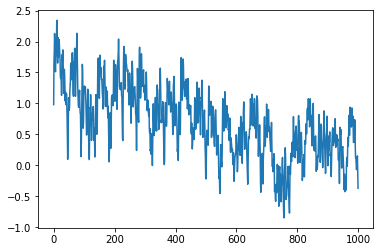

In [ ]:
i=500
j=4
signal=X_train[i,:,j]
plt.plot(signal)

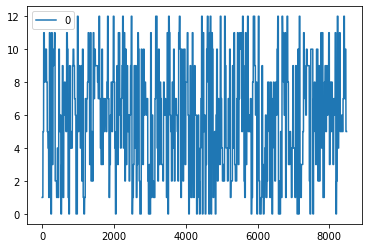

In [ ]:
pd.DataFrame(np.array(y_train)).plot()

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
 

In [ ]:
num_classes=13
n_timesteps=1000
n_features=8

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
batch_size = 16
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
alpha = 0.425
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha), input_shape=(n_timesteps,n_features)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.35))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 999, 128)          2176      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 499, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 498, 64)           16448     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 249, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 248, 32)           4128      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 124, 32)         

In [ ]:
checkpoint=ModelCheckpoint("/content/trained_model/hma_base_CNN.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=20,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=5,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=epochs, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks)

Epoch 1/100
530/530 [==============================] - ETA: 0s - loss: 1.3860 - accuracy: 0.4875
Epoch 1: val_loss improved from inf to 0.71342, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 11s 19ms/step - loss: 1.3860 - accuracy: 0.4875 - val_loss: 0.7134 - val_accuracy: 0.7008 - lr: 0.0010
Epoch 2/100
527/530 [============================>.] - ETA: 0s - loss: 0.7308 - accuracy: 0.7432
Epoch 2: val_loss did not improve from 0.71342
530/530 [==============================] - 6s 11ms/step - loss: 0.7313 - accuracy: 0.7430 - val_loss: 0.9066 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 3/100
525/530 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.8432
Epoch 3: val_loss improved from 0.71342 to 0.54108, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.4322 - accuracy: 0.8433 - val_loss: 0.5411 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 4/100
530/530 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8434
Epoch 4: val_loss improved from 0.54108 to 0.47575, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.5608 - accuracy: 0.8434 - val_loss: 0.4758 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 5/100
528/530 [============================>.] - ETA: 0s - loss: 0.2603 - accuracy: 0.9023
Epoch 5: val_loss improved from 0.47575 to 0.24158, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.2611 - accuracy: 0.9021 - val_loss: 0.2416 - val_accuracy: 0.9060 - lr: 0.0010
Epoch 6/100
527/530 [============================>.] - ETA: 0s - loss: 0.3789 - accuracy: 0.8888
Epoch 6: val_loss did not improve from 0.24158
530/530 [==============================] - 5s 10ms/step - loss: 0.3789 - accuracy: 0.8886 - val_loss: 0.4360 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 7/100
525/530 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.8733
Epoch 7: val_loss did not improve from 0.24158
530/530 [==============================] - 6s 10ms/step - loss: 0.5913 - accuracy: 0.8736 - val_loss: 0.6413 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 8/100
528/530 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9183
Epoch 8: val_loss did not improve from 0.24158
530/530 [==============================] - 6s 11ms/step - loss: 0.2399 - accuracy: 0.9182 - val_loss: 0.2910 - val_accuracy: 0.9021 -

INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.0902 - accuracy: 0.9718 - val_loss: 0.2040 - val_accuracy: 0.9204 - lr: 2.0000e-04
Epoch 12/100
529/530 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9806
Epoch 12: val_loss did not improve from 0.20400
530/530 [==============================] - 6s 10ms/step - loss: 0.0621 - accuracy: 0.9807 - val_loss: 0.2304 - val_accuracy: 0.9215 - lr: 2.0000e-04
Epoch 13/100
530/530 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9816
Epoch 13: val_loss improved from 0.20400 to 0.19688, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.1969 - val_accuracy: 0.9392 - lr: 2.0000e-04
Epoch 14/100
528/530 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9828
Epoch 14: val_loss improved from 0.19688 to 0.17609, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.0535 - accuracy: 0.9829 - val_loss: 0.1761 - val_accuracy: 0.9408 - lr: 2.0000e-04
Epoch 15/100
529/530 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9806
Epoch 15: val_loss did not improve from 0.17609
530/530 [==============================] - 6s 11ms/step - loss: 0.0524 - accuracy: 0.9807 - val_loss: 0.1870 - val_accuracy: 0.9369 - lr: 2.0000e-04
Epoch 16/100
527/530 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9845
Epoch 16: val_loss did not improve from 0.17609
530/530 [==============================] - 5s 10ms/step - loss: 0.0482 - accuracy: 0.9846 - val_loss: 0.2000 - val_accuracy: 0.9436 - lr: 2.0000e-04
Epoch 17/100
529/530 [============================>.] - ETA: 0s - loss: 0.0455 - accuracy: 0.9843
Epoch 17: val_loss improved from 0.17609 to 0.17150, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 13ms/step - loss: 0.0457 - accuracy: 0.9842 - val_loss: 0.1715 - val_accuracy: 0.9403 - lr: 2.0000e-04
Epoch 18/100
527/530 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9858
Epoch 18: val_loss improved from 0.17150 to 0.16837, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.0719 - accuracy: 0.9858 - val_loss: 0.1684 - val_accuracy: 0.9403 - lr: 2.0000e-04
Epoch 19/100
525/530 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9904
Epoch 19: val_loss did not improve from 0.16837
530/530 [==============================] - 5s 10ms/step - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.1830 - val_accuracy: 0.9441 - lr: 2.0000e-04
Epoch 20/100
529/530 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9896
Epoch 20: val_loss did not improve from 0.16837
530/530 [==============================] - 6s 10ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.1946 - val_accuracy: 0.9480 - lr: 2.0000e-04
Epoch 21/100
527/530 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9915
Epoch 21: val_loss did not improve from 0.16837
530/530 [==============================] - 6s 10ms/step - loss: 0.0343 - accuracy: 0.9915 - val_loss: 0.1725 - val_

INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


530/530 [==============================] - 7s 14ms/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.1385 - val_accuracy: 0.9491 - lr: 2.0000e-04
Epoch 23/100
529/530 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9882
Epoch 23: val_loss did not improve from 0.13849
530/530 [==============================] - 6s 11ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.2419 - val_accuracy: 0.9298 - lr: 2.0000e-04
Epoch 24/100
530/530 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9882
Epoch 24: val_loss did not improve from 0.13849
530/530 [==============================] - 5s 10ms/step - loss: 0.0389 - accuracy: 0.9882 - val_loss: 0.2856 - val_accuracy: 0.9408 - lr: 2.0000e-04
Epoch 25/100
529/530 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9913
Epoch 25: val_loss did not improve from 0.13849
530/530 [==============================] - 5s 10ms/step - loss: 0.0365 - accuracy: 0.9913 - val_loss: 0.3614 - val_

In [ ]:
class_names=["healthy","uhbf0","uhbf6","uhbf20","uhbf35","uhcf0","uhcf6","uhcf20","uhcf35","uhor0","uhor6","uhor20","uhor35"]

In [ ]:
y_pred_probs=model.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

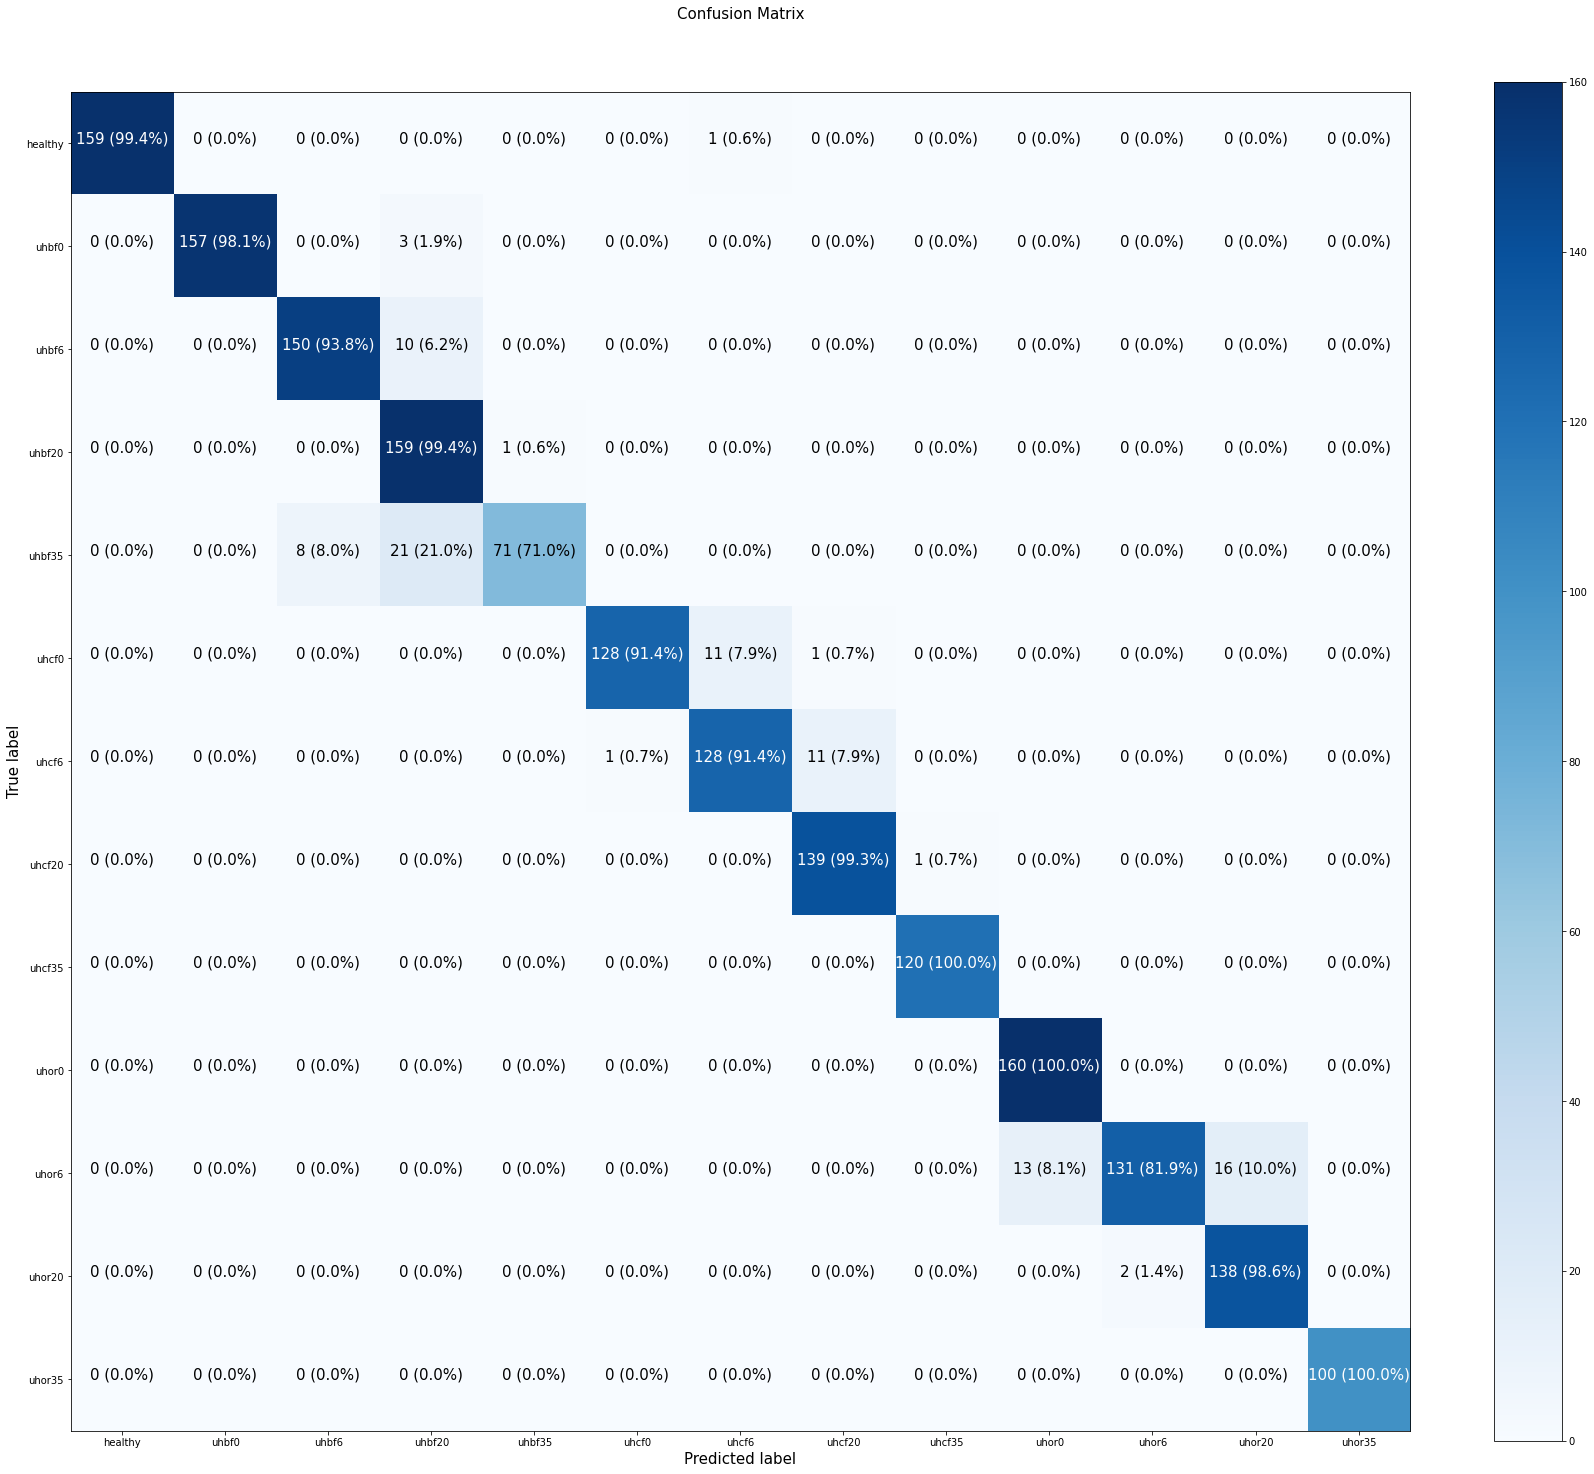

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(30,25))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       160
       uhbf0       1.00      0.98      0.99       160
       uhbf6       0.95      0.94      0.94       160
      uhbf20       0.82      0.99      0.90       160
      uhbf35       0.99      0.71      0.83       100
       uhcf0       0.99      0.91      0.95       140
       uhcf6       0.91      0.91      0.91       140
      uhcf20       0.92      0.99      0.96       140
      uhcf35       0.99      1.00      1.00       120
       uhor0       0.92      1.00      0.96       160
       uhor6       0.98      0.82      0.89       160
      uhor20       0.90      0.99      0.94       140
      uhor35       1.00      1.00      1.00       100

    accuracy                           0.95      1840
   macro avg       0.95      0.94      0.94      1840
weighted avg       0.95      0.95      0.94      1840



In [ ]:
model.evaluate(X_test,y_test)

58/58 [==============================] - 0s 8ms/step - loss: 0.2776 - accuracy: 0.9457


[0.2775561809539795, 0.945652186870575]

In [ ]:
!zip -r /content/drive/MyDrive/FYP_FINAL/UHBF/cnn_trained_model_apr.zip /content/trained_model

## EWT + CNN


In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_val.npy")


In [ ]:
X_train.shape,X_test.shape,X_val.shape

((8480, 1000, 8), (1840, 1000, 8), (1820, 1000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((8480,), (1840,), (1820,))

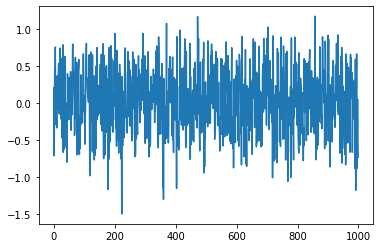

In [ ]:
i=500
j=1
signal=X_train[i,:,j]
plt.plot(signal)

In [ ]:
# Standardising and applying ewt transform
scaler=StandardScaler()
ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(signal.reshape(-1,1)).reshape(-1),N=201)

In [ ]:
ewt.shape

(1000, 201)

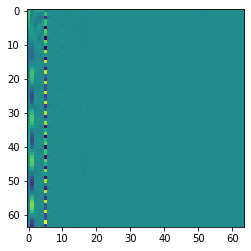

In [ ]:
plt.imshow(resize(ewt,(64,64)))

In [ ]:
train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
# Runtime is approx  10 hrs
train_data_ewt = np.ndarray(shape=(train_size, 64, 64, 8))
train_data_ewt = np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_train_data_ewt_epoch5599.npy")

for i in range(5550,train_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,train_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,train_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_train_data_ewt_epoch{}'.format(i),train_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_train[i,:,j].reshape(-1,1)).reshape(-1), N = 201)
        train_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_train_data_ewt_full',train_data_ewt)

In [ ]:
# Takes 180 mins
val_data_ewt = np.ndarray(shape=(val_size, 64, 64, 8))
val_data_ewt = np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_val_data_ewt_epoch1599.npy")

for i in range(1580,val_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,val_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,val_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_val_data_ewt_epoch{}'.format(i),val_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_val[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        val_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_val_data_ewt_full',val_data_ewt)

In [ ]:
# Takes 180 mins
test_data_ewt = np.ndarray(shape=(test_size, 64, 64, 8))
test_data_ewt = np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_test_data_ewt_epoch1799.npy")

for i in range(1780,test_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,test_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,test_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_test_data_ewt_epoch{}'.format(i),test_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_test[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        test_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Saving 1799/1840 features
Processsing 1800/1840 features


In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_test_data_ewt_full',test_data_ewt)

### Setting correct shapes

In [ ]:
train_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_train_data_ewt_full.npy")
test_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_test_data_ewt_full.npy")
val_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/uhbf_val_data_ewt_full.npy")


In [ ]:
train_data_ewt.shape, test_data_ewt.shape, val_data_ewt.shape

((8480, 64, 64, 8), (1840, 64, 64, 8), (1820, 64, 64, 8))

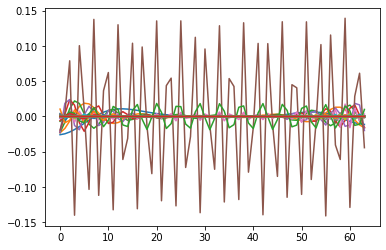

In [ ]:
plt.plot(train_data_ewt[1870][:,:,0]);

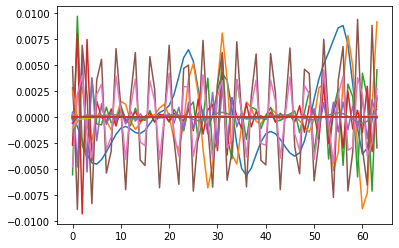

In [ ]:
plt.plot(test_data_ewt[100][:,:,0]);

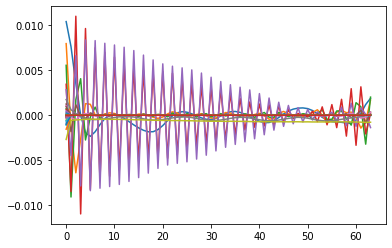

In [ ]:
plt.plot(val_data_ewt[100][:,:,0]);

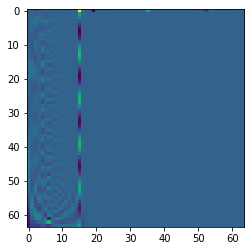

In [ ]:
plt.imshow(train_data_ewt[100][:,:,0]);

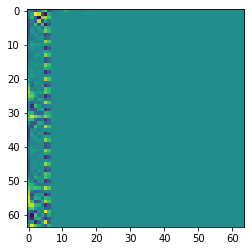

In [ ]:
plt.imshow(test_data_ewt[100][:,:,0]);

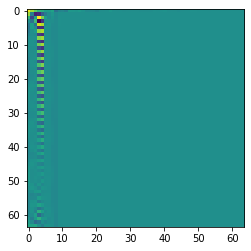

In [ ]:
plt.imshow(val_data_ewt[100][:,:,0]);

In [ ]:
y_train=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/UHBF/y_val.npy")

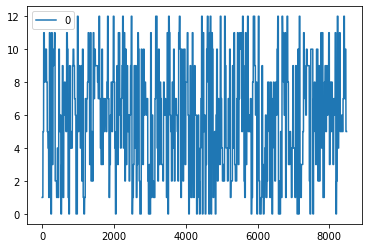

In [ ]:
pd.DataFrame(y_train).plot()

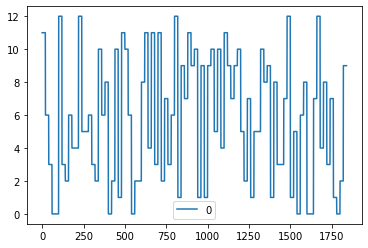

In [ ]:
pd.DataFrame(y_test).plot()

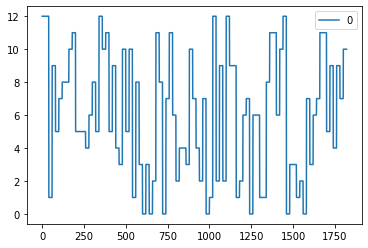

In [ ]:
pd.DataFrame(y_val).plot()

In [ ]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([680, 700, 680, 680, 540, 680, 680, 680, 600, 680, 680, 680, 520]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([160, 160, 160, 160, 100, 140, 140, 140, 120, 160, 160, 140, 100]))

In [ ]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([140, 140, 140, 140, 120, 160, 140, 160, 120, 140, 140, 160, 120]))

In [ ]:
# y_train = list(map(lambda x: int(x), y_train))
# y_test = list(map(lambda x: int(x), y_test))
# y_val = list(map(lambda x: int(x),y_val))

X_train = train_data_ewt
# y_train = list(y_train)
X_test = test_data_ewt
# y_test = list(y_test)
X_val = val_data_ewt
# y_val = list(y_val)

In [ ]:
img_x = 64
img_y = 64
img_z = 8
input_shape = (img_x, img_y, img_z)
num_classes=13
 

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
 

In [ ]:
np.unique(y_train,return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([680, 700, 680, 680, 540, 680, 680, 680, 600, 680, 680, 680, 520]))

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((8480, 64, 64, 8), (1840, 64, 64, 8), (1820, 64, 64, 8))

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((8480, 13), (1840, 13), (1820, 13))

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        2336      
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

### Training

In [ ]:
batch_size = 32
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
monitor = "val_loss"
checkpoint=ModelCheckpoint("/content/trained_model/EWT_CNN.hd5",monitor=monitor,mode="mminax",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor=monitor,min_delta=0,patience=10,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor=monitor,factor=0.2,patience=5,verbose=1,min_delta=0.0001)

# callbacks=[checkpoint,earlystop,reduce_lr]
callbacks=[checkpoint,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=100, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks)
 
 

Epoch 1/100
263/265 [============================>.] - ETA: 0s - loss: 2.5460 - accuracy: 0.0872
Epoch 1: val_loss improved from inf to 2.56379, saving model to /content/trained_model/EWT_CNN.hd5
INFO:tensorflow:Assets written to: /content/trained_model/EWT_CNN.hd5/assets
265/265 [==============================] - 20s 30ms/step - loss: 2.5457 - accuracy: 0.0873 - val_loss: 2.5638 - val_accuracy: 0.0670 - lr: 1.0000e-04
Epoch 2/100
262/265 [============================>.] - ETA: 0s - loss: 2.3472 - accuracy: 0.1564
Epoch 2: val_loss improved from 2.56379 to 2.56009, saving model to /content/trained_model/EWT_CNN.hd5
INFO:tensorflow:Assets written to: /content/trained_model/EWT_CNN.hd5/assets
265/265 [==============================] - 6s 24ms/step - loss: 2.3446 - accuracy: 0.1580 - val_loss: 2.5601 - val_accuracy: 0.0815 - lr: 1.0000e-04
Epoch 3/100
264/265 [============================>.] - ETA: 0s - loss: 2.0905 - accuracy: 0.2415
Epoch 3: val_loss improved from 2.56009 to 2.55552, sa

In [ ]:
# !zip -r /content/drive/MyDrive/FYP_FINAL/HMA/hma_trained_model.zip /content/trained_model

### Evaluation

In [ ]:
classifier = model
# classifier=tf.keras.models.load_model("/content/trained_model/EWT_CNN.hd5")

In [ ]:
class_names=["healthy","0.5mm","1mm","1.5mm","2mm"]

In [ ]:
y_pred_probs=classifier.predict(X_train)
y_true=np.argmax(y_train,axis=1)

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

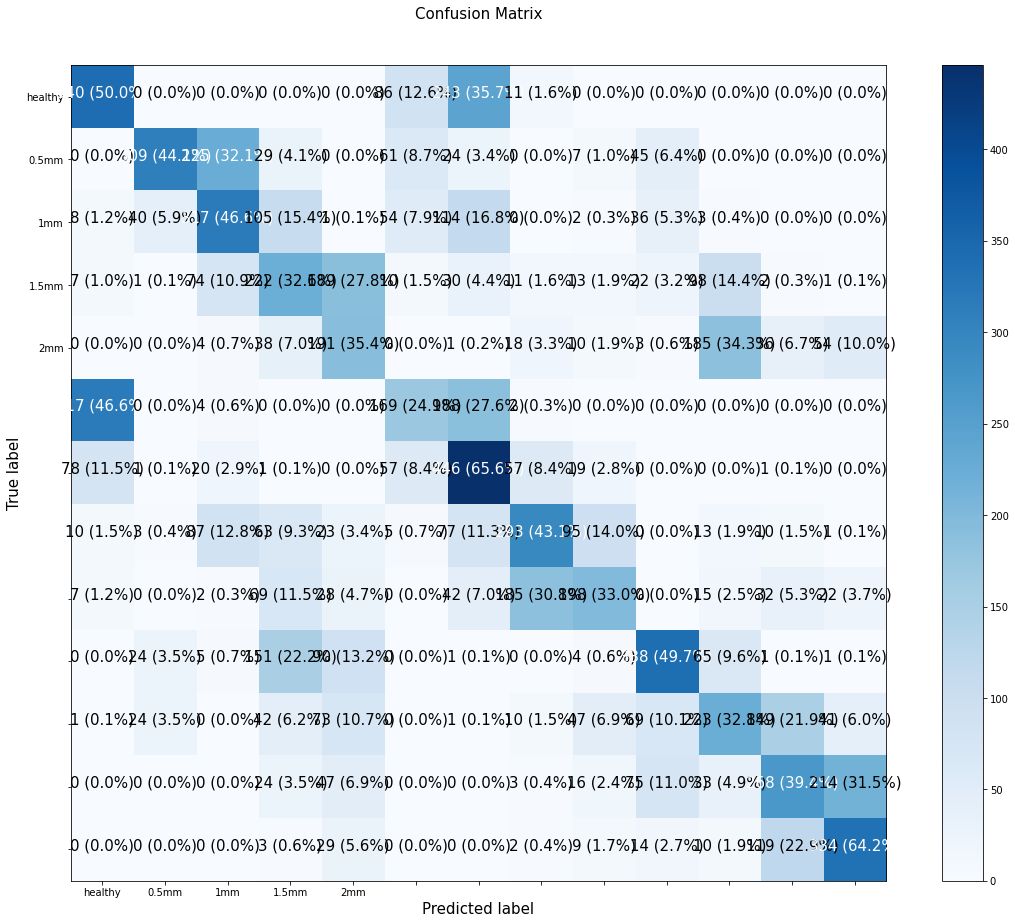

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(20,15))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

ValueError: ignored

In [ ]:
model.evaluate(X_train ,y_train)

In [ ]:
model.evaluate(X_val,y_val)

In [ ]:
model.evaluate(X_test,y_test)